In [1]:
#imports

import pandas as pd
import numpy as np
import json
import matplotlib
%matplotlib inline

import joblib

# Outline

- Begin the process by taking a look at the *training* data basic features:
    - Event code counts
    - unique installations
    - unique sessions
- Add another layer by looking at grouped features:
    - group by installation id: game time, event code counts,
    - group by session within an installation
- Compare train and test data as a reality check
- Unpack inner data
    - event data
    - specs args
- Join the train_labels to train data
- Set up an initial naive baseline

In [2]:
#Read in training data first
train = pd.read_csv("data-science-bowl-2019/train.csv")

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
train.shape

(11341042, 11)

In order to explore the features more easily let's sample a small piece of the total. Total shape has over 11 million observations.
It's also worth noting that some of the installation ids in the training data don't contain assessments so we can eliminate those as they are not useful for training.

In [5]:
hasAssessmentIds = train[train["type"] == "Assessment"].loc[:,'installation_id'].drop_duplicates()
useful_train = pd.merge(train, hasAssessmentIds, on="installation_id", how="inner")

In [104]:
useful_train.shape

(8294138, 11)

In [105]:
train_sample = useful_train.sample(100000)

Let's list out the columns we're going to need to look at for each observation.

In [106]:
train_sample.columns

Index(['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world'],
      dtype='object')

It seems like it could be useful to categorize different observations in the data. Event codes could represent some of these differences.

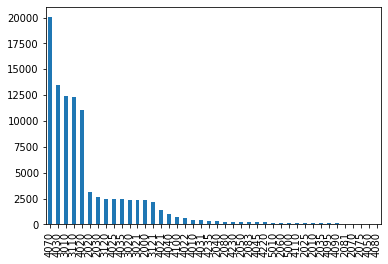

In [107]:
train_sample["event_code"].value_counts().plot.bar()

In [108]:
train_sample.groupby("installation_id").sum()

,event_count,event_code,game_time
installation_id,,,
0006a69f,3242,181819,3347729
0006c192,3630,161086,3633287
00129856,867,31530,999164
001d0ed0,901,47590,869382
00225f67,818,30476,785277
...,...,...,...
ff9715db,789,52832,914783
ffc90c32,1503,83194,2003772
ffd2871d,2070,115282,3795167


This tells us there are about 4000 installation ids in the sample and gives us information about total game time.

In [11]:
train_sample.groupby("game_session").sum()

,event_count,event_code,game_time
game_session,,,
000050630c4b081b,24,4070,59879
0000d473b2f78883,168,11110,214507
00020f3bd042b3f0,33,6020,55364
00030865234e6b3d,31,4020,40806
000319989d08f8aa,398,10250,568087
...,...,...,...
fffb2fe838347917,88,3020,224151
fffc152654849cbe,97,2020,96792
fffc54cfd9f4d7b2,57,4030,153328


Not sure game session ids are telling me what I thought they were here. They don't seem to overlap much, some sessions only contining 1 obseravtion.

Let's take a deeper look at a set of events for a single ID.

In [12]:
single_id = train_sample.query('installation_id=="0006a69f"')
single_id.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2907,f71c4741,6693061f235f04a7,2019-08-09T18:27:19.526Z,"{""description"":""Which soap is just right for t...",0006a69f,63,3010,38219,Scrub-A-Dub,Game,MAGMAPEAK
1795,9e4c8c7b,faed1805baea37b0,2019-08-06T17:46:52.516Z,"{""media_type"":""animation"",""duration"":4042,""des...",0006a69f,35,3110,51504,All Star Sorting,Game,TREETOPCITY
140,26fd2d99,0336db4dee65ad4b,2019-08-06T05:01:47.802Z,"{""round_target"":{""size"":1,""type"":""Soap"",""anima...",0006a69f,37,2020,34512,Scrub-A-Dub,Game,MAGMAPEAK
456,02a42007,05921a6eb858eeba,2019-08-06T05:15:54.858Z,"{""rocket"":5,""coordinates"":{""x"":519,""y"":602,""st...",0006a69f,63,4030,63548,Fireworks (Activity),Activity,TREETOPCITY
1689,e9c52111,7a4ee0624abb5ef8,2019-08-06T05:50:31.289Z,"{""jar"":[{""color"":""pink"",""amount"":2},{""color"":""...",0006a69f,41,2030,52634,Bottle Filler (Activity),Activity,MAGMAPEAK


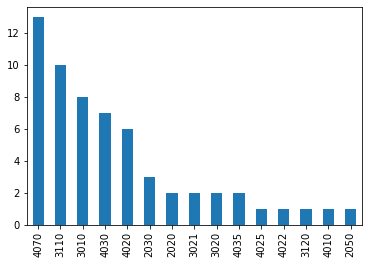

In [13]:
single_id["event_code"].value_counts().plot.bar()

In [14]:
#This user has 25 different game sessions
single_id["game_session"].value_counts().count()

31

In [15]:
single_id["type"].value_counts()

Game          29
Activity      26
Assessment     5
Name: type, dtype: int64

It might be interesting to compare some features in the train data to the test data, as a reality check that things are relatively similar.

In [16]:
test = pd.read_csv("data-science-bowl-2019/test.csv")

In [17]:
test.shape

(1156414, 11)

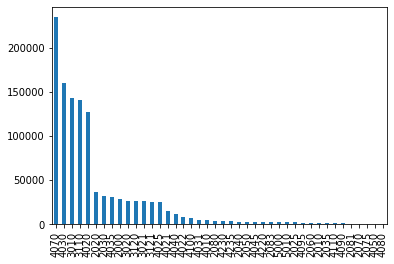

In [18]:
test["event_code"].value_counts().plot.bar()

Event code, at least, looks fairly similar. That's good!
Next, let's look at various other statistics.

In [19]:
display(train_sample["event_code"].nunique())
display(test["event_code"].nunique())

42

42

In [20]:
display(train_sample["event_id"].nunique())
display(test["event_id"].nunique())

362

365

In [21]:
display(train_sample["installation_id"].nunique())
display(test["installation_id"].nunique())

4052

1000

Unpack the inner data

In [22]:
# Code below based on code original written/published by Gabriel Preda
# on Kaggle, accessed Mon, 18 Nov, 2019
# https://www.kaggle.com/gpreda/2019-data-science-bowl-eda
extracted_event_data = pd.io.json.json_normalize(train_sample.event_data.apply(json.loads))

In [23]:
extracted_event_data.shape

(100000, 136)

In [24]:
extracted_event_data.head()

,description,identifier,media_type,duration,round,event_count,game_time,event_code,bottles,source,...,tape_length,bug_length,time_played,round_prompt,toy_earned,molds,max_position,end_position,dwell_time,chests
0,That's too much food. Try taking a piece off t...,1437,animation,950.0,3.0,72,82886.0,3120,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,5.0,73,84022.0,4030,"[{'color': 'blue', 'amount': 2}, {'color': 'bl...",8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,18,22229.0,4020,NaN,scale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Let's set off these fireworks. We can drag the...,"Dot_LetsFireworks,Dot_DragAnyHeight",audio,4175.0,NaN,5,4175.0,3110,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,87,74830.0,4030,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


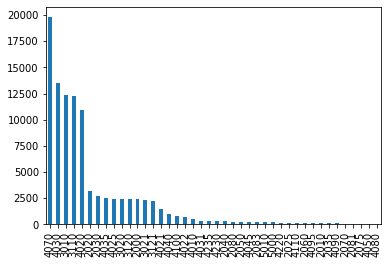

In [25]:
extracted_event_data["event_code"].value_counts().plot.bar()

Join the labels to the training set.

In [26]:
train_labels = pd.read_csv("data-science-bowl-2019/train_labels.csv")

In [27]:
# Code below based on code original written/published by Gabriel Preda
# on Kaggle, accessed Mon, 18 Nov, 2019
# https://www.kaggle.com/gpreda/2019-data-science-bowl-eda

numerical_columns = ['game_time']
categorical_columns = ['type', 'world']

comp_train_sample = pd.DataFrame({'installation_id': train_sample['installation_id'].unique()})
comp_train_sample.set_index('installation_id', inplace = True)

In [28]:
def get_numeric_columns(df, column):
    df = df.groupby('installation_id').agg({f'{column}': ['mean', 'sum', 'min', 'max', 'std', 'skew']})
    df[column].fillna(df[column].mean(), inplace = True)
    df.columns = [f'{column}_mean', f'{column}_sum', f'{column}_min', f'{column}_max', f'{column}_std', f'{column}_skew']
    return df

In [29]:
for i in numerical_columns:
    comp_train_sample = comp_train_sample.merge(get_numeric_columns(train_sample, i), left_index = True, right_index = True)

/home/maxwell/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [30]:
# get the mode of the title
labels_map = dict(train_labels.groupby('title')['accuracy_group'].agg(lambda x:x.value_counts().index[0]))
# merge target
labels = train_labels.loc[:, ['installation_id', 'title', 'accuracy_group']]
# replace title with the mode
labels['title'] = labels['title'].map(labels_map)
# join train with labels
comp_train_sample = labels.merge(comp_train_sample, on = 'installation_id', how = 'left')
print('We have {} training rows'.format(comp_train_sample.shape[0]))

We have 17690 training rows


This gives us the number of rows we can actually use in a future model.

## Let's establish a naive baseline model to work from

In [31]:
# Code below based on code original written/published by Massoud Hosseinali
# on Kaggle, accessed 20 Nov, 2019
# https://www.kaggle.com/mhviraf/a-baseline-for-dsb-2019
submission = pd.read_csv("data-science-bowl-2019/sample_submission.csv")

In [32]:
labels_map = dict(train_labels.groupby('title')['accuracy_group'].agg(lambda x:x.value_counts().index[0])) # get the mode
labels_map

{'Bird Measurer (Assessment)': 0,
 'Cart Balancer (Assessment)': 3,
 'Cauldron Filler (Assessment)': 3,
 'Chest Sorter (Assessment)': 0,
 'Mushroom Sorter (Assessment)': 3}

In [33]:
submission['accuracy_group'] = test.groupby('installation_id').last()['title'].map(labels_map).reset_index(drop=True)
submission.to_csv('submission.csv', index=None)
display(submission.shape)
submission.head()

(1000, 2)

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


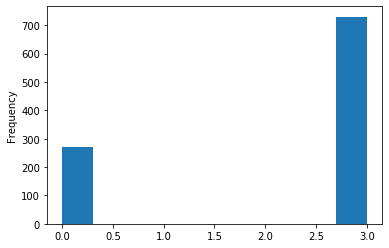

In [34]:
submission['accuracy_group'].plot(kind='hist')

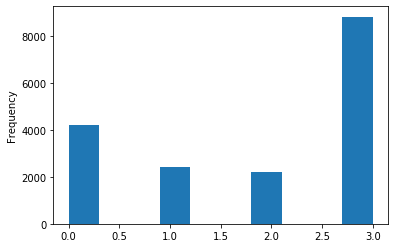

In [35]:
train_labels['accuracy_group'].plot(kind='hist')

### Use joblib to save the data extracted

In [ ]:
joblib.dump(train_sample, "")

## Make a slightly better predictive baseline with KNN

First, the data needs to be prepared for the KNN. The following code creates summary statistics to be used.

In [109]:
#first we need to make a mapping to the proper event code for a completion of each event

#list all activity titles
list_of_user_activities = list(set(train_sample['title'].value_counts().index).union(set(test['title'].value_counts().index)))
#map each activity to its integer index (very simple hash)
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))

# modify the df (essentially a rename)
train_sample['title'] = train_sample['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)

#assessment successful event, or win code, is 4100 for most
#assesments but 4110 for the final
#make a mapping for this 
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

In [110]:
#convert the time data
train_sample['timestamp'] = pd.to_datetime(train_sample['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [111]:
# create a function to summarize the data in each session

def agg_data(data, test_set=False):
    
    activityData = []
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_incorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    durations = []
    last_activity = 0
    
    for i, session in data.groupby('game_session', sort=False):
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        
        #if we find an assessment and a session
        #look at assessment data
        if (session_type == 'Assessment') & (len(session) > 1):
            
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            #check true or false by searching json event data str
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            
            features = user_activities_count.copy()
            
            #baseline the number of attempts
            features['session_title'] = session['title'].iloc[0] 
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_incorrect_attempts'] = accumulated_incorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_incorrect_attempts += false_attempts
            
            #recalc average of the duration
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)
            
            #compute accuracy as described in the competition
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
                
            
            features.update(accuracy_groups)
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            features['accumulated_actions'] = accumulated_actions
            accumulated_accuracy_group += features['accuracy_group']
            accuracy_groups[features['accuracy_group']] += 1
                
            if true_attempts+false_attempts > 0:
                activityData.append(features)
                
            counter += 1
        
        # sum total actions for a session
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
                
    return activityData

In [112]:
#compile data for each installation id by running above function
compiled_data = []
for i, (ins_id, data) in enumerate(train_sample.groupby('installation_id', sort=False)):
    compiled_data += agg_data(data)

new_train_sample = pd.DataFrame(compiled_data)
del compiled_data
new_train_sample.shape

(244, 16)

In [114]:
all_features = [x for x in new_train_sample.columns if x not in ['accuracy_group']]
X, y = new_train_sample[all_features], new_train_sample['accuracy_group']
X.shape

(244, 15)

Fit and predict based on the model:

In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

oof = np.zeros(len(X))

NFOLDS = 2
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=2019)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    currX = X.loc[trn_idx, all_features]
    scaler = StandardScaler()
    scaler.fit(currX)
    currX_sc = scaler.transform(currX)
    
    # K-Nearest Neighbors Model
    model = KNeighborsClassifier(n_neighbors=6)
    model.fit(currX_sc, y.loc[trn_idx])
    oof[test_idx] = model.predict(currX_sc)


cohen_kappa_score(y, oof)

0.05297884727343283

Looks like this model is pretty poor but it's possible the features are not really set up properly for a KNN classification.